In [41]:
"""Fuse 1000 RGB-D images from the 7-scenes dataset into a TSDF voxel volume with 2cm resolution.
"""

import time
import os
import cv2
import numpy as np
from scipy.spatial.transform import RigidTransform as Tf
import fusion
import matplotlib.pyplot as plt


In [ ]:
  # ======================================================================================================== #
  # (Optional) This is an example of how to compute the 3D bounds
  # in world coordinates of the convex hull of all camera view
  # frustums in the dataset
  # ======================================================================================================== #
print("Estimating voxel volume bounds...")
n_imgs = 1000
cam_intr = np.loadtxt("data/camera-intrinsics.txt", delimiter=' ')
vol_bnds = np.zeros((3,2))
for i in range(n_imgs):
    # Read depth image and camera pose
    depth_im = cv2.imread("data/frame-%06d.depth.png"%(i),-1).astype(float)
    depth_im /= 1000.  # depth is saved in 16-bit PNG in millimeters
    depth_im[depth_im == 65.535] = 0  # set invalid depth to 0 (specific to 7-scenes dataset)
    cam_pose = np.loadtxt("data/frame-%06d.pose.txt"%(i))  # 4x4 rigid transformation matrix

# Compute camera view frustum and extend convex hull
    view_frust_pts = fusion.get_view_frustum(depth_im, cam_intr, cam_pose)
    vol_bnds[:,0] = np.minimum(vol_bnds[:,0], np.amin(view_frust_pts, axis=1))
    vol_bnds[:,1] = np.maximum(vol_bnds[:,1], np.amax(view_frust_pts, axis=1))
# ======================================================================================================== #

# ======================================================================================================== #
# Integrate
# ======================================================================================================== #
    # Initialize voxel volume
print("Initializing voxel volume...")
tsdf_vol = fusion.TSDFVolume(vol_bnds, voxel_size=0.02)

# Loop through RGB-D images and fuse them together
t0_elapse = time.time()
for i in range(n_imgs):
    print("Fusing frame %d/%d"%(i+1, n_imgs))

    # Read RGB-D image and camera pose
    color_image = cv2.cvtColor(cv2.imread("data/frame-%06d.color.jpg"%(i)), cv2.COLOR_BGR2RGB)
    depth_im = cv2.imread("data/frame-%06d.depth.png"%(i),-1).astype(float)
    depth_im /= 1000.
    depth_im[depth_im == 65.535] = 0
    cam_pose = np.loadtxt("data/frame-%06d.pose.txt"%(i))

    # Integrate observation into voxel volume (assume color aligned with depth)
    tsdf_vol.integrate(color_image, depth_im, cam_intr, cam_pose, obs_weight=1.)

fps = n_imgs / (time.time() - t0_elapse)
print("Average FPS: {:.2f}".format(fps))

# Get mesh from voxel volume and save to disk (can be viewed with Meshlab)
print("Saving mesh to mesh.ply...")
verts, faces, norms, colors = tsdf_vol.get_mesh()
fusion.meshwrite("mesh.ply", verts, faces, norms, colors)

# Get point cloud from voxel volume and save to disk (can be viewed with Meshlab)
print("Saving point cloud to pc.ply...")
point_cloud = tsdf_vol.get_point_cloud()
fusion.pcwrite("pc.ply", point_cloud)

In [42]:
%matplotlib inline

In [12]:
cam_intr = np.loadtxt("data/camera-intrinsics.txt", delimiter=' ')

p_1 = np.loadtxt("data/frame-%06d.pose.txt"%(1))
p_2 = np.loadtxt("data/frame-%06d.pose.txt"%(2))

print(p_1)
print("-----------")
print(p_2)





[[ 0.90874106  0.27250862 -0.31597188 -0.33866197]
 [-0.27249488  0.96105307  0.04515439  0.01591677]
 [ 0.31598061  0.04506832  0.94763422  0.29782206]
 [ 0.          0.          0.          1.        ]]
-----------
[[ 0.90877688  0.27293819 -0.31549683 -0.34053639]
 [-0.27268934  0.9609642   0.04586313  0.01700522]
 [ 0.31570891  0.04435452  0.94775832  0.29744455]
 [ 0.          0.          0.          1.        ]]


In [13]:
pose = Tf.from_matrix(p_1)
pose.translation

array([-0.33866197,  0.01591677,  0.29782206])

In [17]:
np.loadtxt("data/frame-%06d.pose.txt"%(1))

array([[ 0.90874106,  0.27250862, -0.31597188, -0.33866197],
       [-0.27249488,  0.96105307,  0.04515439,  0.01591677],
       [ 0.31598061,  0.04506832,  0.94763422,  0.29782206],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
ddir = 'carla_exploration_mvp_20250714_170630/'
np.loadtxt(os.path.join(ddir, "matrix_step_0000.txt"), delimiter=' ')


os.path.join(ddir, "matrix_step_%04d.txt"%(i))

os.path.join(ddir, "depth_step_%04d.txt"%(i))

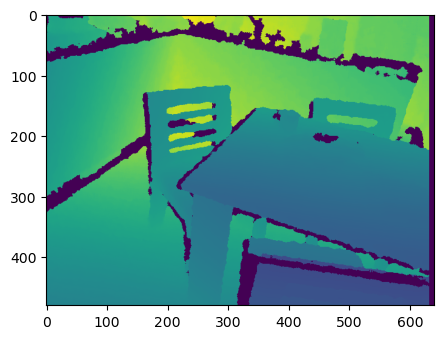

In [50]:
depth_im = cv2.imread("data/frame-%06d.depth.png"%(1),-1).astype(float)
depth_im /= 1000.
depth_im[depth_im == 65.535] = 0

carla_im = cv2.imread(os.path.join(ddir, "depth_step_%04d.png"%(1)),-1).astype(float)

depth_im
# carla_im

plt.figure(figsize=(5, 5))
plt.imshow(depth_im)


In [34]:
carla_im = cv2.imread(os.path.join(ddir, "depth_step_%04d.png"%(1)))

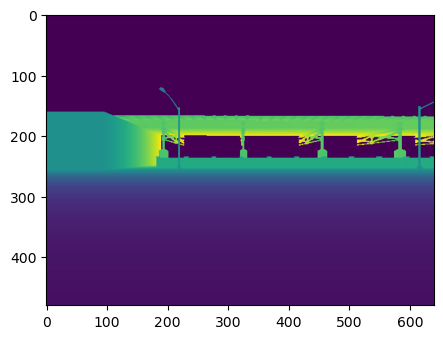

In [71]:
plt.figure(figsize=(5, 5))
ddir = 'carla_exploration_mvp_20250714_170630/'
max_range_m = 60.0

carla_im = cv2.imread(os.path.join(ddir, "depth_step_%04d.png"%(1)))

rgb    = np.asarray(carla_im, dtype=np.uint32)
r, g, b = rgb[..., 2], rgb[..., 1], rgb[..., 0]
n  = (r + g*256 + b*256*256) / (256**3 - 1)

depth_m = n * 1000.0 
depth_m[depth_m > max_range_m] = 0.0
depth_mm = (depth_m * 1000.0).astype(np.uint16)
plt.imshow(depth_mm)


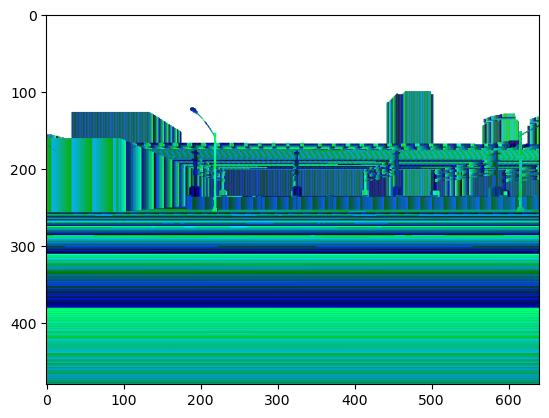

In [54]:
carla_im = cv2.imread(os.path.join(ddir, "depth_step_%04d.png"%(1)))
plt.imshow(carla_im)


## Color

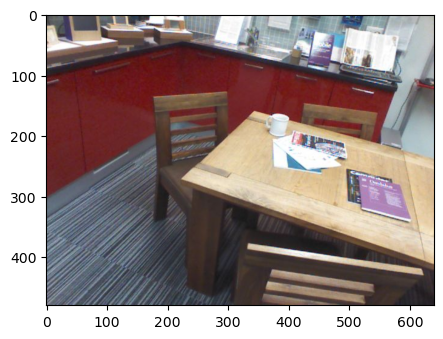

In [ ]:
color_image = cv2.cvtColor(cv2.imread("data/frame-%06d.color.jpg"%(i)), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(color_image)

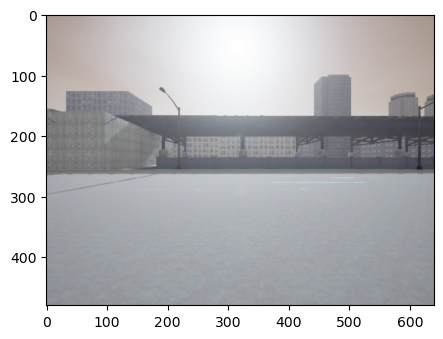

In [76]:
color_image = cv2.imread(os.path.join(ddir, "rgb_step_%04d.png"%(1)))
plt.figure(figsize=(5, 5))
plt.imshow(color_image)

# Carla


In [72]:
def carla_to_tsdf(img, max_range_m=60.0):
    rgb    = np.asarray(img, dtype=np.uint32)
    r, g, b = rgb[..., 2], rgb[..., 1], rgb[..., 0]
    n  = (r + g*256 + b*256*256) / (256**3 - 1)

    depth_m = n * 1000.0 
    depth_m[depth_m > max_range_m] = 0.0
    depth_mm = (depth_m * 1000.0).astype(np.uint16)
    return depth_mm

In [ ]:
  # ======================================================================================================== #
  # (Optional) This is an example of how to compute the 3D bounds
  # in world coordinates of the convex hull of all camera view
  # frustums in the dataset
  # ======================================================================================================== #
ddir = 'carla_exploration_mvp_20250714_170630/'

print("Estimating voxel volume bounds...")
n_imgs = 100
cam_intr = np.loadtxt("data/camera-intrinsics.txt", delimiter=' ')
vol_bnds = np.zeros((3,2))
for i in range(n_imgs):
    # Read depth image and camera pose
    depth_im = cv2.imread(os.path.join(ddir, "depth_step_%04d.png"%(1)))
    depth_im = carla_to_tsdf(depth_im)
    #depth_im[depth_im == 65.535] = 0  # set invalid depth to 0 (specific to 7-scenes dataset)
    cam_pose = np.loadtxt(os.path.join(ddir, "matrix_step_%04d.txt"%(i)))  # 4x4 rigid transformation matrix

# Compute camera view frustum and extend convex hull
    view_frust_pts = fusion.get_view_frustum(depth_im, cam_intr, cam_pose)
    vol_bnds[:,0] = np.minimum(vol_bnds[:,0], np.amin(view_frust_pts, axis=1))
    vol_bnds[:,1] = np.maximum(vol_bnds[:,1], np.amax(view_frust_pts, axis=1))
# ======================================================================================================== #

# ======================================================================================================== #
# Integrate
# ======================================================================================================== #
    # Initialize voxel volume
print("Initializing voxel volume...")
tsdf_vol = fusion.TSDFVolume(vol_bnds, voxel_size=0.02)

# Loop through RGB-D images and fuse them together
t0_elapse = time.time()
for i in range(n_imgs):
    print("Fusing frame %d/%d"%(i+1, n_imgs))

    # Read RGB-D image and camera pose
    color_image = cv2.imread(os.path.join(ddir, "rgb_step_%04d.png"%(1)))
    depth_im = cv2.imread(os.path.join(ddir, "depth_step_%04d.png"%(1)))
    depth_im = carla_to_tsdf(depth_im)
    cam_pose = np.loadtxt(os.path.join(ddir, "matrix_step_%04d.txt"%(i)))  # 4x4 rigid transformation matrix

    # Integrate observation into voxel volume (assume color aligned with depth)
    tsdf_vol.integrate(color_image, depth_im, cam_intr, cam_pose, obs_weight=1.)

fps = n_imgs / (time.time() - t0_elapse)
print("Average FPS: {:.2f}".format(fps))

# Get mesh from voxel volume and save to disk (can be viewed with Meshlab)
print("Saving mesh to mesh.ply...")
verts, faces, norms, colors = tsdf_vol.get_mesh()
fusion.meshwrite("mesh.ply", verts, faces, norms, colors)

# Get point cloud from voxel volume and save to disk (can be viewed with Meshlab)
print("Saving point cloud to pc.ply...")
point_cloud = tsdf_vol.get_point_cloud()
fusion.pcwrite("pc.ply", point_cloud)